<a href="https://colab.research.google.com/github/Blijf/Datathon/blob/master/Datathon_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CARGA DE DATOS

#### Imports

In [0]:
#INTALL PACKAGES
#!pip install category_encoders
#IMPORTS
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import export_graphviz
from sklearn import preprocessing
import os
from graphviz import Source
import plotly.plotly as py
import cufflinks as cf


#### Lectura del dataset

In [0]:
df_model=pd.read_csv('Modelar_UH2019.txt', sep="|" )
df_esti=pd.read_csv('Estimar_UH2019.txt', sep="|")

#### Combinación de ambos datasets en uno único

    Concatenamos ambos datasets, es decir, el de modelar y el de estimar en un conjunto único. De esta forma, tenemos un mayor número de datos a los que manejar.

In [0]:
#axis=0 (eje horizontal) y #axis=1 (eje vertical)
#df_total= pd.concat([df_model, df_esti],axis=0) 
#df_total.shape
#df_total.tail()

# POST-ANÁLISIS 

#### Observar la distribución que siguen los datos

In [238]:
df_model.describe()

,HY_id,HY_cod_postal,HY_antiguedad,HY_metros_utiles,HY_metros_totales,HY_num_banos,HY_num_terrazas,HY_ascensor,HY_trastero,HY_num_garajes,HY_precio,HY_precio_anterior,IDEA_area,IDEA_poblacion,IDEA_densidad,IDEA_pc_1960,IDEA_pc_1960_69,IDEA_pc_1970_79,IDEA_pc_1980_89,IDEA_pc_1990_99,IDEA_pc_2000_10,IDEA_pc_comercio,IDEA_pc_industria,IDEA_pc_oficina,IDEA_pc_otros,IDEA_pc_residencial,IDEA_pc_trast_parking,IDEA_ind_tienda,IDEA_ind_turismo,IDEA_ind_alimentacion,IDEA_ind_riqueza,IDEA_rent_alquiler,IDEA_ind_elasticidad,IDEA_ind_liquidez,IDEA_unitprice_sale_residential,IDEA_price_sale_residential,IDEA_stock_sale_residential,IDEA_demand_sale_residential,IDEA_unitprice_rent_residential,IDEA_price_rent_residential,IDEA_stock_rent_residential,IDEA_demand_rent_residential,GA_page_views,GA_mean_bounce,GA_exit_rate,GA_quincena_ini,GA_quincena_ult,TARGET
count,9.958000e+03,9958.000000,4474.000000,7.072000e+03,9.924000e+03,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9.958000e+03,6.800000e+03,7327.000000,7323.000000,7323.000000,7248.000000,7248.000000,7248.000000,7248.000000,7248.000000,7248.000000,7248.000000,7248.000000,7248.000000,7248.000000,7248.000000,7248.000000,7241.000000,7241.000000,7241.000000,7327.000000,6896.000000,4852.000000,4852.000000,7323.000000,7.323000e+03,7323.000000,7323.000000,6960.000000,6960.000000,6960.000000,7323.00000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000
mean,6.272842e+06,24008.655654,1997.306214,4.714240e+02,5.433917e+02,0.819642,0.019984,0.270436,0.062161,0.097007,7.672430e+04,8.939254e+04,5128.812502,10139.938004,34.918585,0.114331,0.114331,0.159658,0.132972,0.149433,0.328667,0.021454,0.007529,0.007345,0.054572,0.499603,0.407939,0.328359,0.324650,0.258952,0.164402,5.386890,3.054740,0.014984,1016.892884,1.448905e+05,1097.745596,48.774987,5.164539,601.835398,116.106897,47.52931,190.964652,18.715863,22.209963,14.421370,42.546596,74.155855
std,3.421042e+05,16685.040678,21.089912,2.192031e+04,1.921910e+04,2.913022,0.185066,0.444207,0.241460,0.297337,1.634361e+05,4.314146e+05,10660.457211,8507.308312,71.559554,0.093050,0.093050,0.109443,0.072701,0.074602,0.182306,0.016444,0.013751,0.011161,0.047847,0.079948,0.086394,0.283297,0.328937,0.244020,0.075067,1.295281,1.163774,0.489711,449.799793,8.500210e+04,849.334511,4.444144,1.815746,295.329588,249.668927,13.73609,482.313088,19.983743,20.995044,14.091417,8.404279,89.738992
min,6.028499e+06,2001.000000,1877.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,6.840000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.020000,0.000000,0.000000,0.000000,0.030000,2.500000,1.000000,-1.000000,273.830000,2.857500e+04,3.000000,0.000000,1.000000,180.000000,3.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,6.039048e+06,4800.000000,1992.000000,1.428500e+01,3.170000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,1.050000e+04,1.230000e+04,285.700000,3430.000000,1.040000,0.040000,0.040000,0.090000,0.090000,0.100000,0.190000,0.010000,0.000000,0.000000,0.020000,0.450000,0.350000,0.000000,0.040000,0.000000,0.120000,4.540000,2.000000,0.000000,735.090000,9.996269e+04,456.000000,48.710000,3.980000,442.730000,24.000000,50.94000,6.000000,0.000000,8.612500,2.000000,42.000000,28.655000
50%,6.080821e+06,28980.500000,2007.000000,6.300000e+01,8.100000e+01,1.000000,0.000000,0.000000,0.000000,0.000000,5.970000e+04,6.410000e+04,1391.520000,7693.000000,4.520000,0.100000,0.100000,0.140000,0.120000,0.140000,0.300000,0.020000,0.000000,0.010000,0.040000,0.500000,0.420000,0.330000,0.230000,0.230000,0.140000,5.185000,3.000000,0.000000,910.090000,1.250455e+05,954.000000,49.160000,4.810000,524.140000,57.000000,51.39000,30.000000,14.290000,16.960000,9.000000,46.000000,56.275000
75%,6.528256e+06,43540.000000,2009.000000,9.000000e+01,1.149800e+02,1.000000,0.000000,1.000000,0.000000,0.000000,9.170000e+04,9.710000e+04,4725.

# PRE-PROCESSING

 https://scikit-learn.org/stable/modules/preprocessing.html

#### Crear un subconjunto donde no existen las categorías redundantes

In [0]:
noDesired_columns= ["HY_id","HY_provincia","HY_descripcion","HY_distribucion"]

def no_desired_columns(df,noDesired_columns ):
  total_columns= df.columns.values.tolist()

  sublist= [i for i in total_columns  if i not in noDesired_columns] # selecciona las columnas que no son las indicadas en noDesired_columns
  res_model = df[sublist]
  return res_model

s_df_model=no_desired_columns(df_model,noDesired_columns)

In [0]:
def desired_columns(df,desired_columns):
  total_columns= df.columns.values.tolist()

  sublist= [i for i in total_columns  if i in desired_columns] # selecciona las columnas que no son las indicadas en noDesired_columns
  res_model = df[sublist]
  return res_model

#### Comprobar si hay duplicados

In [0]:
# df_duplicated= no_desired_columns(s_df_model,["TARGET"])
# df_duplicated.loc[df_duplicated.duplicated,:]

In [0]:
# df_duplicated.duplicated().sum()

In [0]:
# s_df_model=df_duplicated.drop_duplicates(keep=False)

#### Transformamos las categorias nominales a númericas

De esta forma se podra utilizar a posteriori los arboles de decisión en la clasificación (https://pbpython.com/categorical-encoding.html)

Obervamos las categorias de tipo nominal o object

In [244]:
obj_df= s_df_model.select_dtypes(include=['object']).columns.tolist()
obj_df
#En el siguiente paso de missins eliminamos HY_cert_energ debido a la gran cantidad de nulls

['HY_tipo', 'HY_cert_energ']

##### Tipo

In [245]:
s_df_model["HY_tipo"].value_counts()

Piso                            4182
Garaje                          2761
Local                            827
Casa de pueblo                   557
Chalet adosado                   433
Trastero                         282
Chalet independiente             209
Solar                            198
Dúplex                           184
Nave adosada                     130
Oficina                          103
Nave aislada                      38
Edificio turístico                17
Otro                              12
Chalet pareado                     9
Ático                              8
Almacén                            3
Edificio comercial                 2
Suelo rústico no urbanizable       2
Aparcamiento                       1
Name: HY_tipo, dtype: int64

Label Encoding



*   Pasamos a categoria los valores nominales(HY_tipo y HY_cert_energ)






In [0]:
lb_make=LabelEncoder()
s_df_model['HY_tipo']=lb_make.fit_transform(s_df_model["HY_tipo"])

In [247]:
s_df_model["HY_tipo"].value_counts()

15    4182
9     2761
10     827
2      557
3      433
18     282
4      209
16     198
6      184
11     130
13     103
12      38
8       17
14      12
5        9
19       8
0        3
7        2
17       2
1        1
Name: HY_tipo, dtype: int64

##### Scaling with outlayers

In [0]:
# robust_scaler= RobustScaler()
# robust_scaled_df = robust_scaler.fit_transform(s_df_model['HY_metros_utiles'])
# s_df_model['HY_metros_utiles_scale'] = pd.DataFrame(robust_scaled_df, columns=s_df_model['HY_metros_utiles'])

#### Missing values 


https://towardsdatascience.com/the-tale-of-missing-values-in-python-c96beb0e8a9d
https://scikit-learn.org/stable/modules/impute.html
https://scikit-learn.org/stable/modules/impute.html


##### Cantidad de null y eliminación de columns

In [249]:
s_df_model.isna().sum()

HY_cod_postal                         0
HY_tipo                               0
HY_antiguedad                      5484
HY_metros_utiles                   2886
HY_metros_totales                    34
HY_num_banos                          0
HY_cert_energ                      8300
HY_num_terrazas                       0
HY_ascensor                           0
HY_trastero                           0
HY_num_garajes                        0
HY_precio                             0
HY_precio_anterior                 3158
IDEA_area                          2631
IDEA_poblacion                     2635
IDEA_densidad                      2635
IDEA_pc_1960                       2710
IDEA_pc_1960_69                    2710
IDEA_pc_1970_79                    2710
IDEA_pc_1980_89                    2710
IDEA_pc_1990_99                    2710
IDEA_pc_2000_10                    2710
IDEA_pc_comercio                   2710
IDEA_pc_industria                  2710
IDEA_pc_oficina                    2710


Eliminamos el certificado de energia debido a la gran cantidad de nulls

In [0]:
s_df_model=s_df_model.drop(['HY_cert_energ'],axis=1)

#### Predición y relleno de nulls (https://stackoverflow.com/questions/40996051/predict-na-missing-values-with-machine-learning)

Nos quedamos con el dataframe sin nulls

In [0]:

nulls_columns=s_df_model.columns[s_df_model.isna().any()]

for i in nulls_columns: 
  target_column=i
  index_of_target = s_df_model.columns.get_loc(target_column)
  #Separamos en notNans y nans
  notnans= s_df_model.notnull().all(axis=1)
  df_notnans= s_df_model[notnans]
  df_nans= s_df_model.loc[~notnans]
  df_nans=no_desired_columns(df_nans,target_column)

  #Rellenamos los nans con la media
  df_nans=df_nans.fillna(0)

  #Objetivo y predcitores para el clasificador
  predictors=no_desired_columns(df_notnans,target_column)
  target=df_notnans[target_column]

  #Clasificador
  reg= DecisionTreeRegressor(min_samples_split=10,min_samples_leaf=1,random_state=None)
#   reg= RandomForestRegressor(n_jobs=2,n_estimators=500)
#   reg= GradientBoostingRegressor(n_estimators=500, max_depth=4,min_samples_split=2,learning_rate=0.01)
  reg.fit(predictors,target)


  #Predicción
  to_predict= df_nans
  name_pred_column=target_column
  to_predict[name_pred_column]= reg.predict(to_predict)
  


In [0]:
#Concatenamos el df predecido y el original sin nans
s_df_model=pd.concat([df_notnans, to_predict],axis=0) 

In [0]:
#s_df_model['TARGET']=s_df_model['TARGET'].fillna(-1)#en ele caso de que cojamos la parte de estimación también

##### Comprobación

In [254]:
np.isnan(s_df_model.any()).sum() 

0

In [255]:
np.isinf(s_df_model.all()).sum()

0

https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py

In [0]:
# rng = np.random.RandomState(0)
# s_df_model[""]= np.sort(rng.normal(loc=0.5, scale=0.25, size=(25, 1)), axis=0)
# qt = QuantileTransformer(n_quantiles=10, random_state=0,output_distribution='normal')
# qt.fit_transform(s_df_model) 

#### Normalización

Outlayers

In [0]:
scaler = preprocessing.RobustScaler()
# scaler = preprocessing.MinMaxScaler()

s_df_model[['HY_metros_utiles','HY_metros_totales']] = scaler.fit_transform(s_df_model[['HY_metros_utiles','HY_metros_totales']])

In [0]:
scalerNorm = preprocessing.Normalizer()
s_df_model[['HY_metros_utiles','HY_metros_totales']] = scalerNorm.fit_transform(s_df_model[['HY_metros_utiles','HY_metros_totales']])

In [0]:
uniform_distr = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
s_df_model[['HY_metros_utiles','HY_metros_totales']] = uniform_distr.fit_transform(s_df_model[['HY_metros_utiles','HY_metros_totales']])

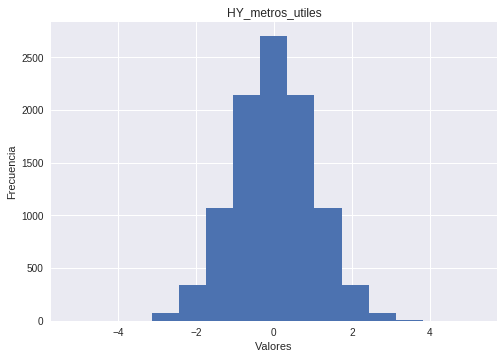

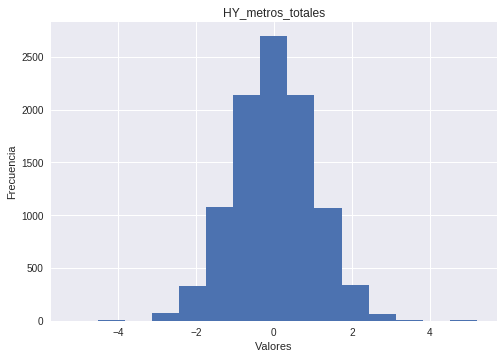

In [261]:
histogramas(s_df_model[['HY_metros_utiles','HY_metros_totales']])

##### Target

Realizamos el ln del Target para acercarnos a  la distribución normal


In [0]:
s_df_model['TARGET']=np.log1p(s_df_model['TARGET'])

#### Category Encoding (http://contrib.scikit-learn.org/categorical-encoding/helmert.html, https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)

In [0]:
#df_model["HY_ascensor"].value_counts()

##### OneHotEncoder

In [208]:
enc=OneHotEncoder(handle_unknown='ignore')
enc.fit_transform(s_df_model)

<9958x36746 sparse matrix of type '<class 'numpy.float64'>'
	with 477984 stored elements in Compressed Sparse Row format>

#EXTRACCIÓN DE CARACTERÍSTICAS


Número de Fotografías

### Descripción 

# PRE-ANALISIS

https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/

In [209]:
s_df_model.head()

,GA_exit_rate,GA_mean_bounce,GA_page_views,GA_quincena_ini,GA_quincena_ult,HY_antiguedad,HY_ascensor,HY_cod_postal,HY_metros_totales,HY_metros_utiles,HY_num_banos,HY_num_garajes,HY_num_terrazas,HY_precio,HY_precio_anterior,HY_tipo,HY_trastero,IDEA_area,IDEA_demand_rent_residential,IDEA_demand_sale_residential,IDEA_densidad,IDEA_ind_alimentacion,IDEA_ind_elasticidad,IDEA_ind_liquidez,IDEA_ind_riqueza,IDEA_ind_tienda,IDEA_ind_turismo,IDEA_pc_1960,IDEA_pc_1960_69,IDEA_pc_1970_79,IDEA_pc_1980_89,IDEA_pc_1990_99,IDEA_pc_2000_10,IDEA_pc_comercio,IDEA_pc_industria,IDEA_pc_oficina,IDEA_pc_otros,IDEA_pc_residencial,IDEA_pc_trast_parking,IDEA_poblacion,IDEA_price_rent_residential,IDEA_price_sale_residential,IDEA_rent_alquiler,IDEA_stock_rent_residential,IDEA_stock_sale_residential,IDEA_unitprice_rent_residential,IDEA_unitprice_sale_residential,TARGET
7,7.26,0.50,168,1,46,2009.0,0,4120,1.856252,2.354920,0,0,0,1010000.0,1230000.0,10,0,2656.34,51.06,49.63,5.18,0.45,4.5,0.0,0.16,0.18,0.36,0.03,0.03,0.11,0.13,0.26,0.43,0.01,0.00,0.00,0.06,0.52,0.40,13767.0,731.75,124148.60,5.78,93.0,1086.0,4.99,925.22,4.399375
15,14.94,30.94,896,1,47,1997.0,0,46370,1.691455,2.046901,2,1,0,265000.0,292000.0,2,0,3219.56,51.05,49.10,1.84,0.20,1.0,0.0,0.16,0.60,0.20,0.16,0.16,0.21,0.14,0.11,0.23,0.01,0.01,0.01,0.06,0.45,0.45,5914.0,583.77,147339.47,5.02,54.0,1518.0,5.43,896.68,4.280132
29,7.96,20.21,409,2,46,2008.0,1,4741,0.827404,1.007991,2,0,0,78300.0,86100.0,15,0,989.50,51.67,49.97,10.76,0.20,3.0,-1.0,0.20,0.20,0.60,0.00,0.00,0.12,0.13,0.23,0.51,0.03,0.00,0.00,0.03,0.58,0.35,10648.0,463.50,80227.29,6.73,27.0,1248.0,4.59,697.20,4.008787
30,8.81,6.25,82,5,47,2008.0,1,4741,-0.010058,0.350026,1,0,0,48800.0,53600.0,15,0,989.50,51.67,49.97,10.76,0.20,3.0,-1.0,0.20,0.20,0.60,0.00,0.00,0.12,0.13,0.23,0.51,0.03,0.00,0.00,0.03,0.58,0.35,10648.0,463.50,80227.29,6.73,27.0,1248.0,4.59,697.20,4.202601
33,30.77,7.69,17,15,44,2008.0,1,4741,-0.032845,0.363059,1,0,0,48600.0,53500.0,15,0,989.50,51.67,49.97,10.76,0.20,3.0,-1.0,0.20,0.20,0.60,0.00,0.00,0.12,0.13,0.23,0.51,0.03,0.00,0.00,0.03,0.58,0.35,10648.0,463.50,80227.29,6.73,27.0,1248.0,4.59,697.20,3.255015


### Distribución

In [210]:
s_df_model.describe()

,GA_exit_rate,GA_mean_bounce,GA_page_views,GA_quincena_ini,GA_quincena_ult,HY_antiguedad,HY_ascensor,HY_cod_postal,HY_metros_totales,HY_metros_utiles,HY_num_banos,HY_num_garajes,HY_num_terrazas,HY_precio,HY_precio_anterior,HY_tipo,HY_trastero,IDEA_area,IDEA_demand_rent_residential,IDEA_demand_sale_residential,IDEA_densidad,IDEA_ind_alimentacion,IDEA_ind_elasticidad,IDEA_ind_liquidez,IDEA_ind_riqueza,IDEA_ind_tienda,IDEA_ind_turismo,IDEA_pc_1960,IDEA_pc_1960_69,IDEA_pc_1970_79,IDEA_pc_1980_89,IDEA_pc_1990_99,IDEA_pc_2000_10,IDEA_pc_comercio,IDEA_pc_industria,IDEA_pc_oficina,IDEA_pc_otros,IDEA_pc_residencial,IDEA_pc_trast_parking,IDEA_poblacion,IDEA_price_rent_residential,IDEA_price_sale_residential,IDEA_rent_alquiler,IDEA_stock_rent_residential,IDEA_stock_sale_residential,IDEA_unitprice_rent_residential,IDEA_unitprice_sale_residential,TARGET
count,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9.958000e+03,9.958000e+03,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.00000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9.958000e+03,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000
mean,22.209963,18.715863,190.964652,14.421370,42.546596,897.363728,0.270436,24008.655654,-0.007821,-1.283205,0.819642,0.097007,0.019984,7.672430e+04,6.104331e+04,11.269432,0.062161,3773.730588,36.990233,35.868571,25.678731,0.188298,1.488411,0.007301,0.120965,0.238768,0.236070,0.083217,0.083217,0.116208,0.096784,0.108766,0.239223,0.015616,0.00548,0.005346,0.039721,0.363639,0.296921,7456.795140,420.644142,1.065508e+05,3.730467,81.151235,807.269632,3.609680,747.811467,3.838718
std,20.995044,19.983743,482.313088,14.091417,8.404279,993.653577,0.444207,16685.040678,1.031371,2.717820,2.913022,0.297337,0.185066,1.634361e+05,3.589139e+05,4.329180,0.241460,9419.679342,22.990577,21.851885,63.268566,0.237913,1.729572,0.341897,0.096958,0.282402,0.315576,0.094293,0.094293,0.117335,0.085730,0.092056,0.213516,0.016970,0.01220,0.010067,0.047499,0.232591,0.195957,8557.509351,370.382115,9.694735e+04,2.709549,215.413424,874.633322,2.813779,591.625492,1.119385
min,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2001.000000,-5.199338,-5.199338,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.612500,0.000000,6.000000,2.000000,42.000000,0.000000,0.000000,4800.000000,-0.674878,-5.199338,0.000000,0.000000,0.000000,1.050000e+04,0.000000e+00,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,3.389631
50%,16.960000,14.290000,30.000000,9.000000,46.000000,0.000000,0.000000,28980.500000,0.000441,0.000028,1.000000,0.000000,0.000000,5.970000e+04,1.345000e+04,10.000000,0.000000,486.420000,51.130000,48.860000,1.680000,0.060000,0.000000,0.000000,0.120000,0.120000,0.080000,0.050000,0.050000,0.100000,0.100000,0.110000,0.210000,0.010000,0.00000,0.000000,0.030000,0.460000,0.380000,4612.000000,450.000000,1.059300e+05,4.600000,27.000000,564.000000,4.100000,774.010000,4.047864
75%,30.000000,29.170000,168.000000,26.000000,47.000000,2007.000000,1.000000,43540.000000,0.674676,0.674831,1.000000,0.000000,0.000000,9.170000e+04,8.037500e+04,15.000000,0.000000,3140.720000,51.740000,49.460000,11.180000,0.340000,3.0

### Correlación

In [0]:
def plot_corr(df,size=10):

  corr = df.corr()
  fig, ax = plt.subplots(figsize=(size, size))
  cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
  fig.colorbar(cax)
  ticks = np.arange(0,len(df.columns),1)
  ax.set_xticks(ticks)
  plt.xticks(rotation=90)
  ax.set_yticks(ticks)
  ax.set_xticklabels(df.columns)
  ax.set_yticklabels(df.columns)
  plt.show()

In [0]:
#  plot_corr(s_df_model,18)

### Histogramas

In [0]:
def histogramas(train):  
  for col in train:

    #regla de sturges 
    k=int(np.ceil(1+np.log2(len(train))))
    plt.hist(train[col], bins= k)
    plt.title(col)
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()



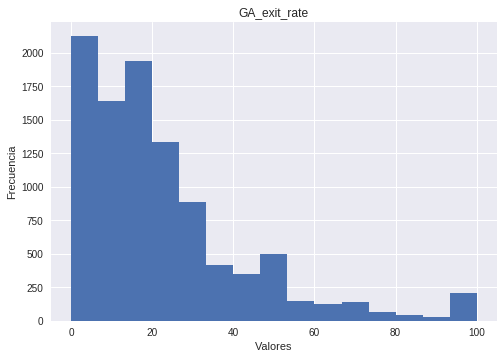

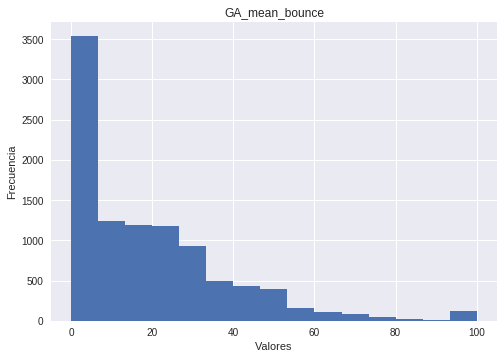

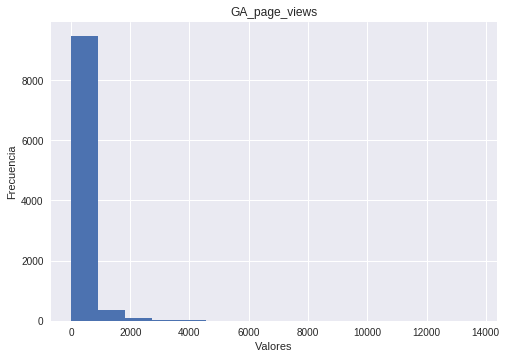

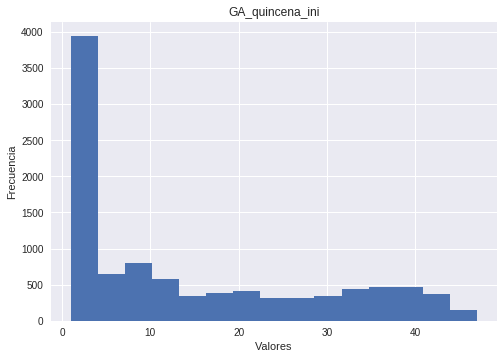

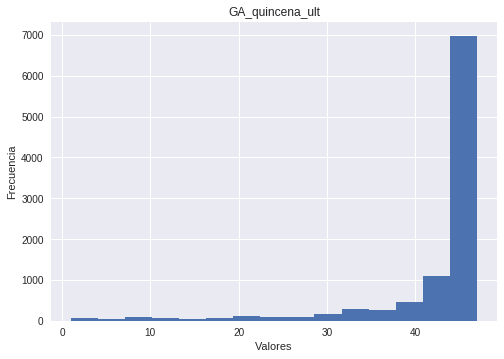

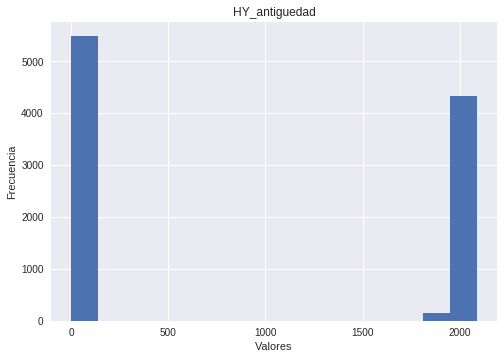

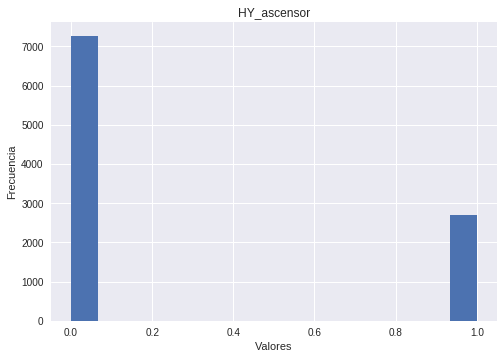

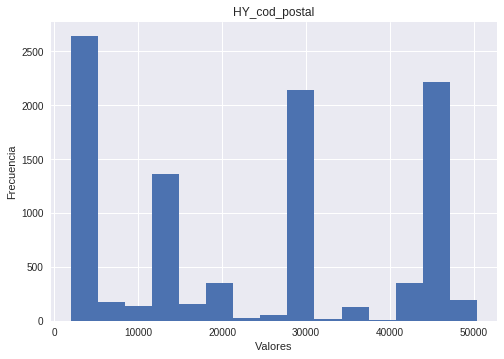

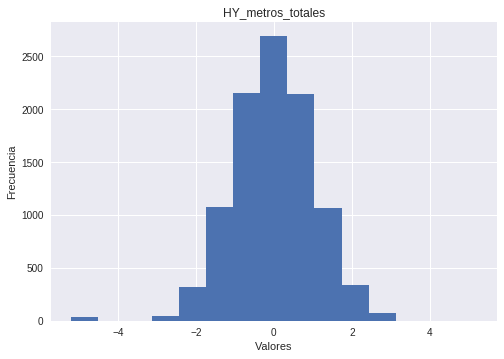

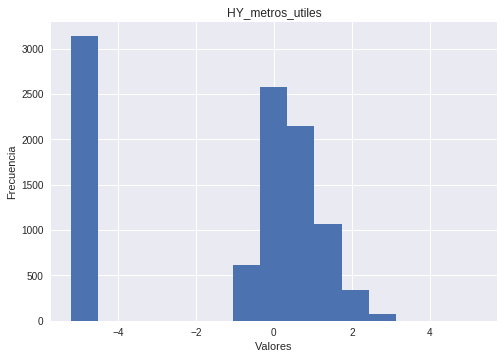

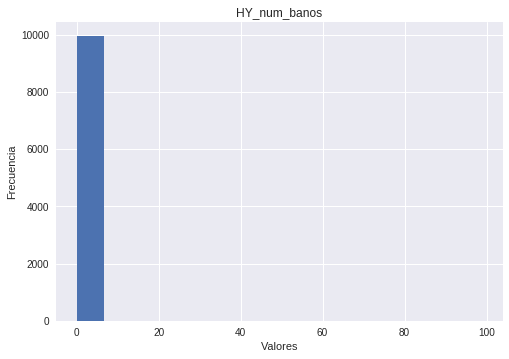

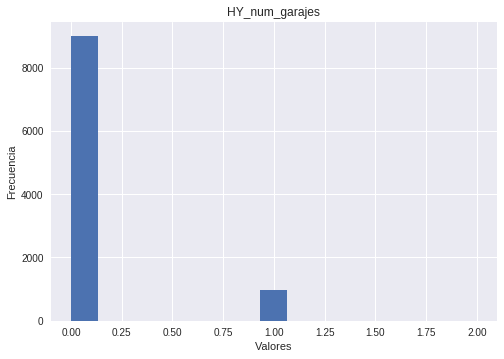

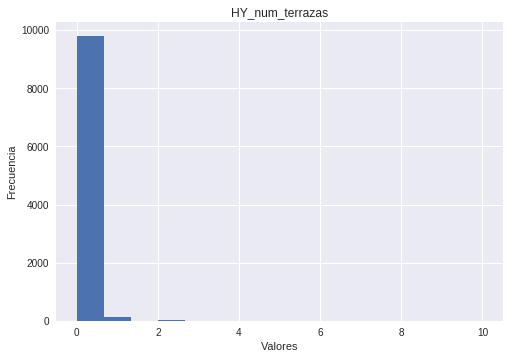

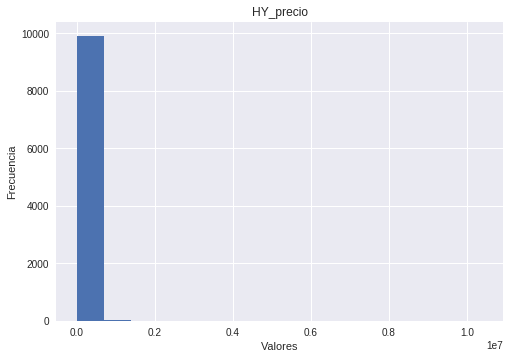

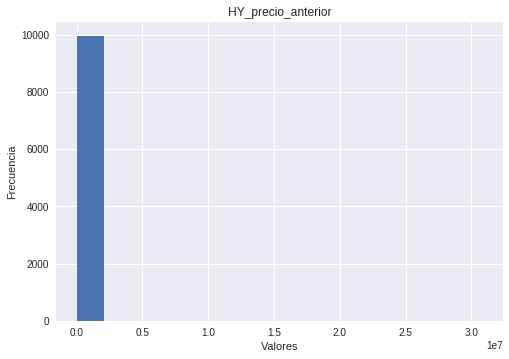

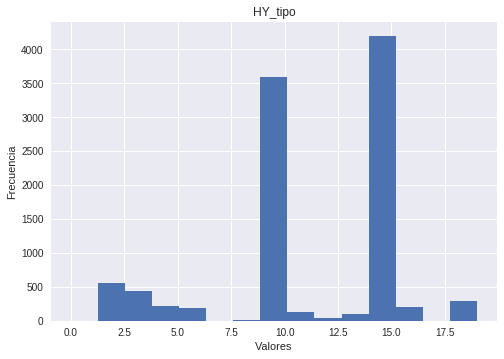

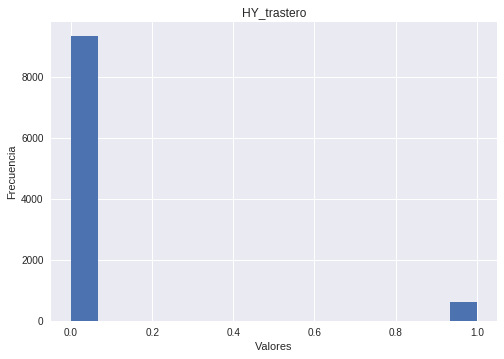

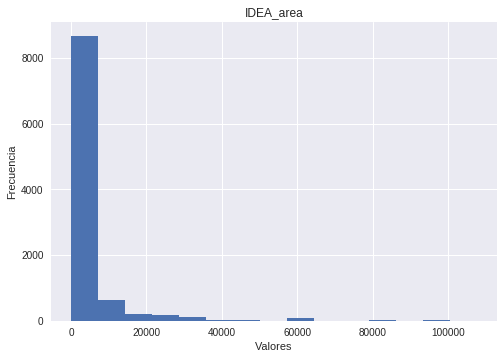

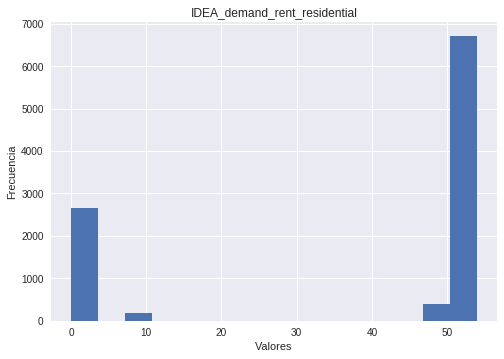

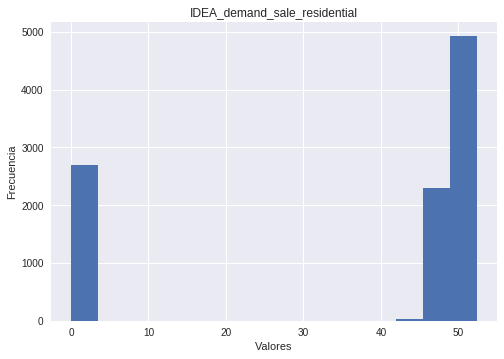

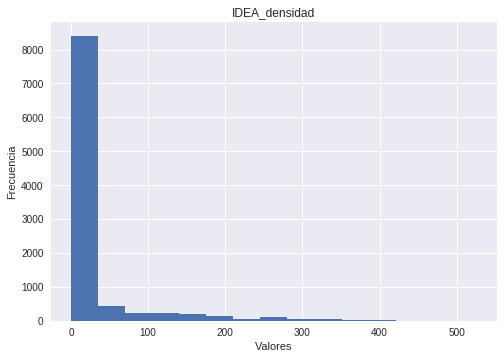

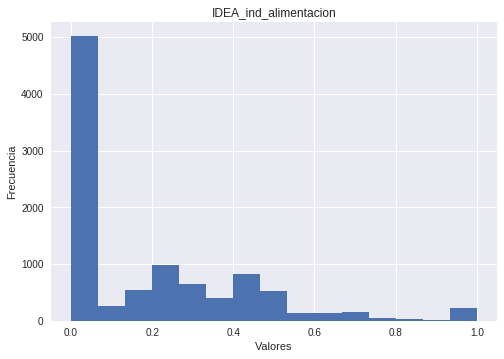

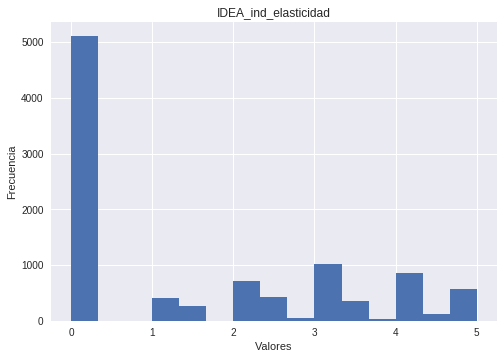

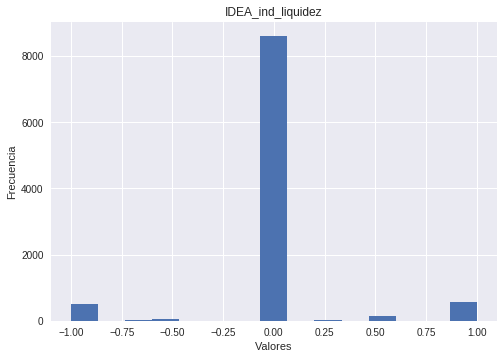

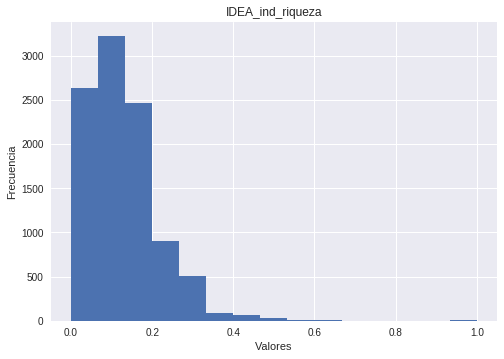

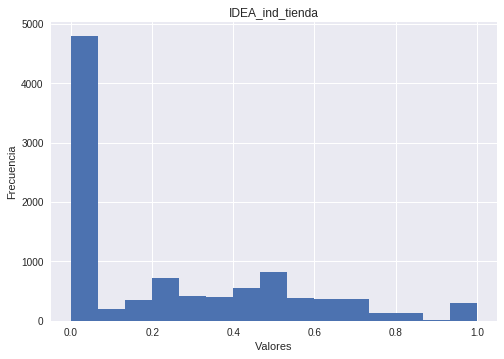

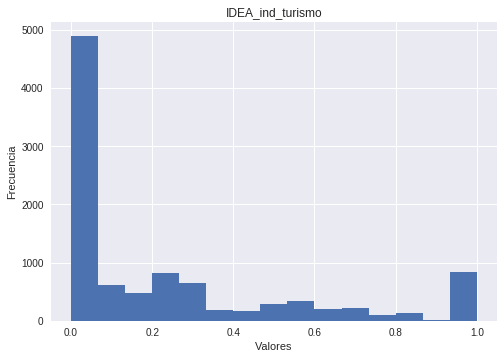

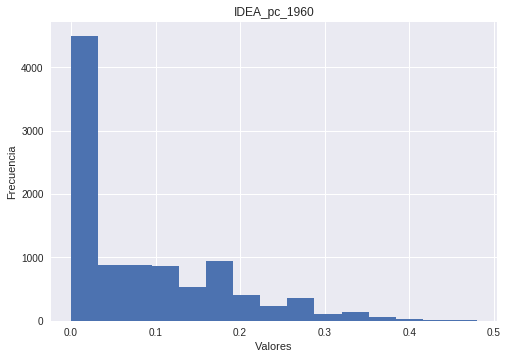

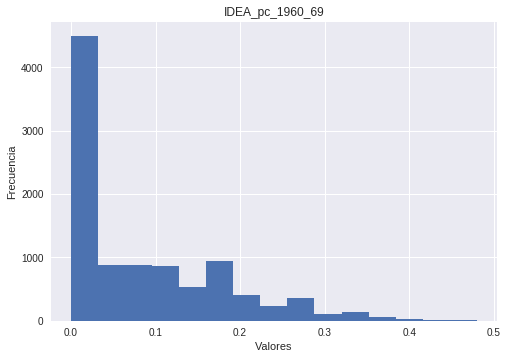

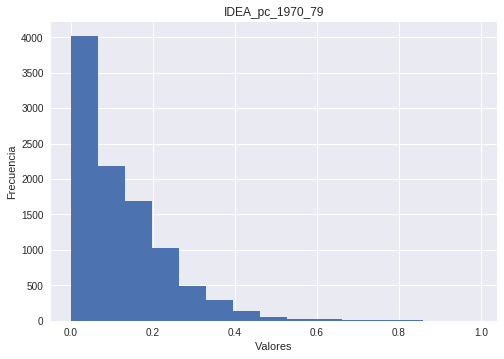

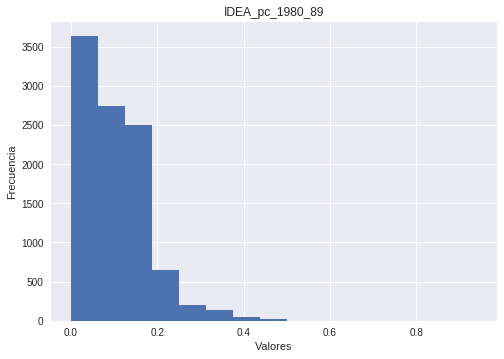

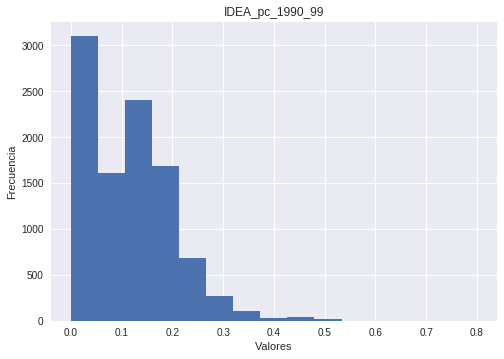

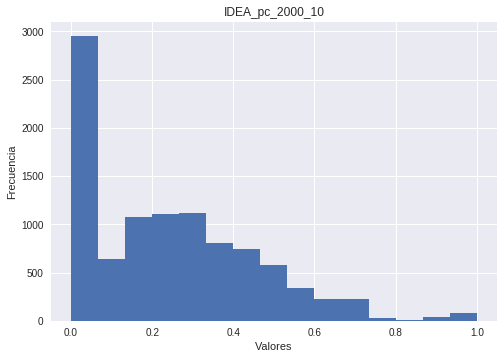

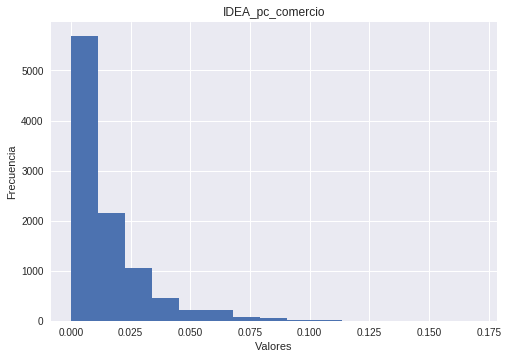

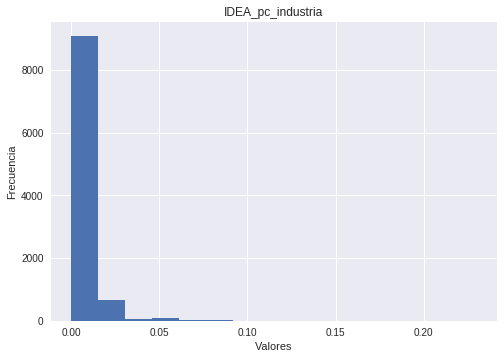

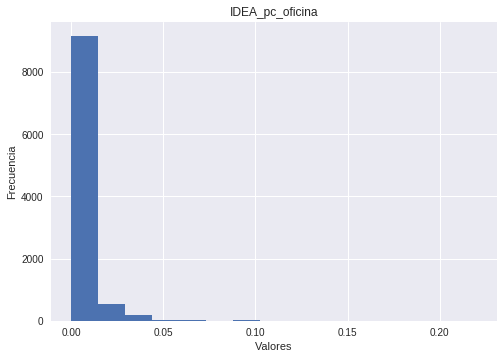

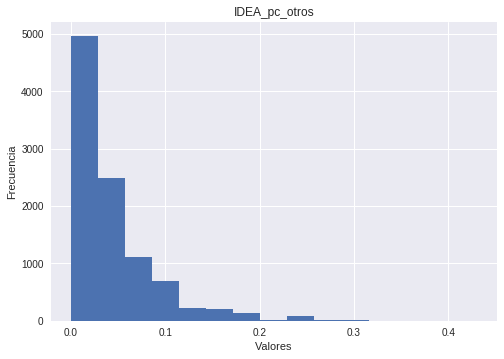

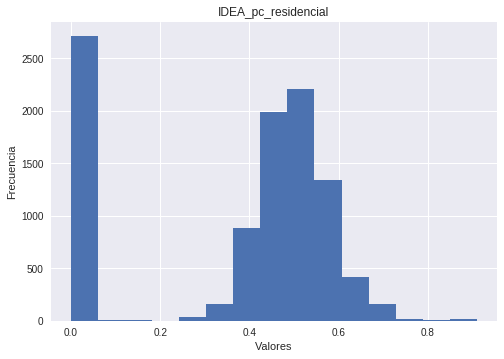

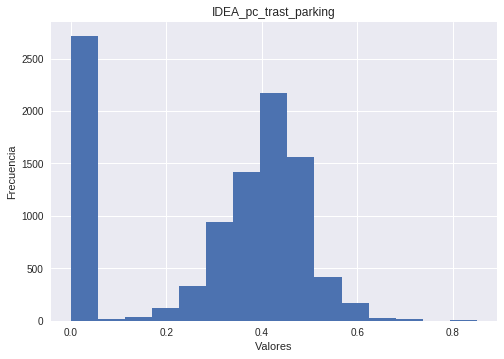

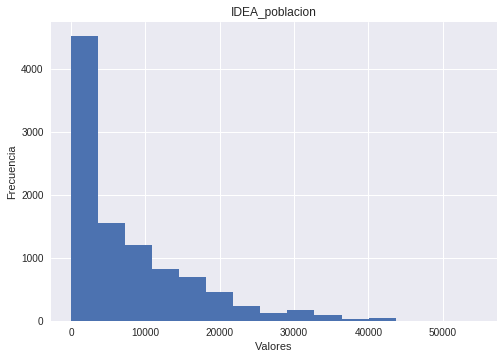

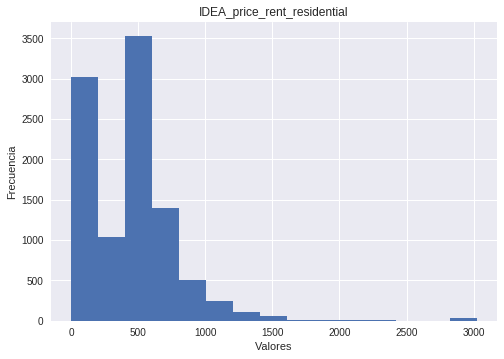

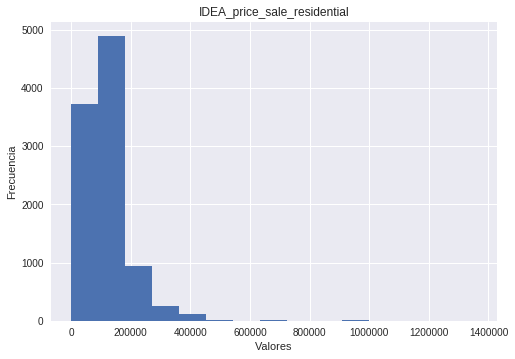

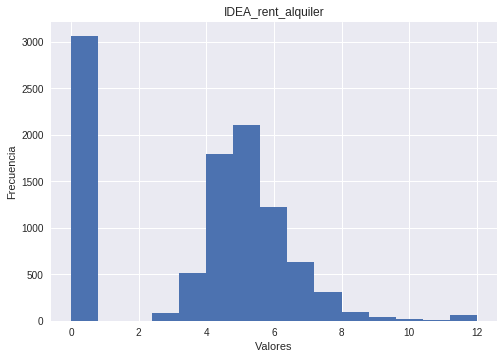

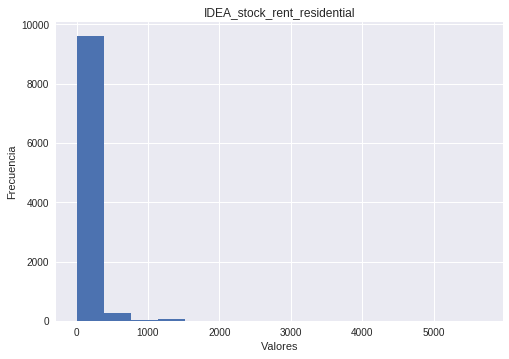

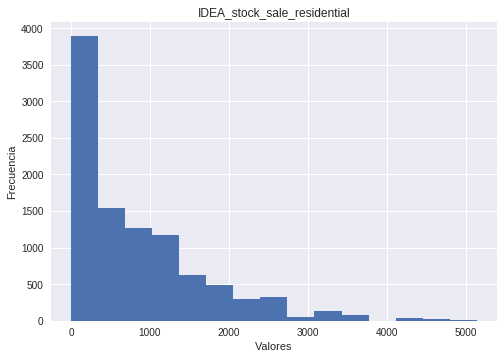

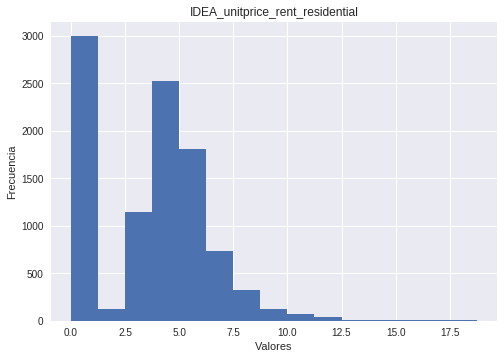

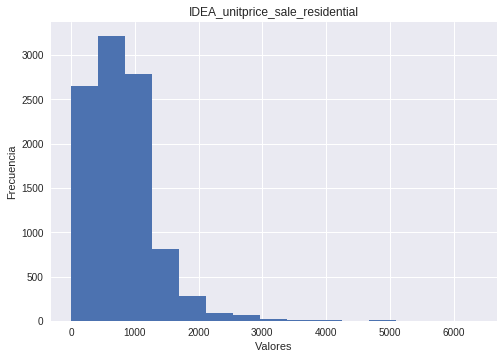

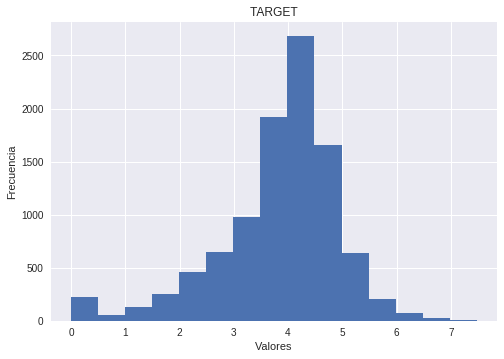

In [214]:
 histogramas(s_df_model)

### Boxplot

In [0]:
def boxplots(train):  
  for col in train:
    plt.boxplot(train[col], dict(markerfacecolor='g', marker='D'),showfliers=True)
    plt.title(col)
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()

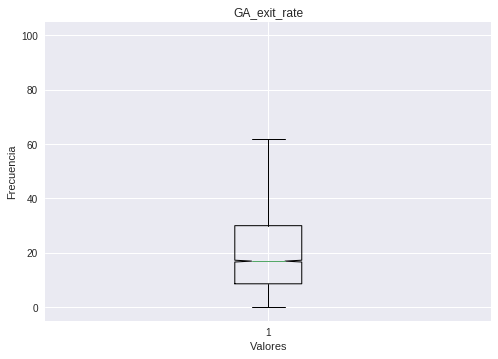

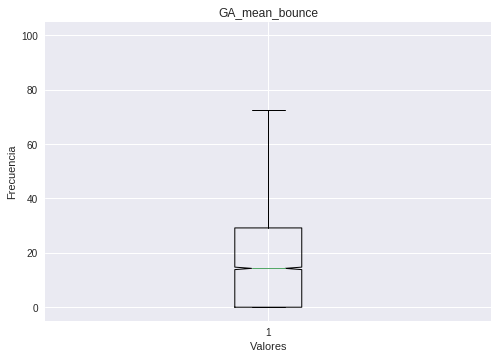

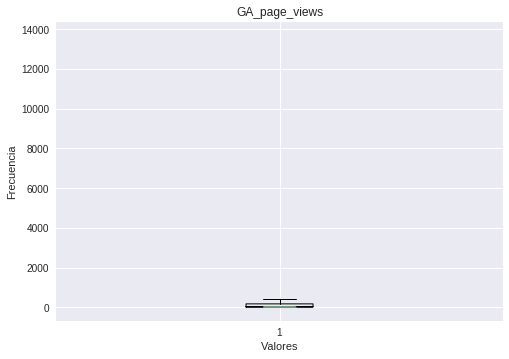

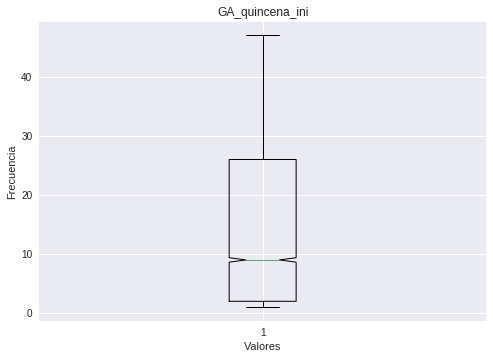

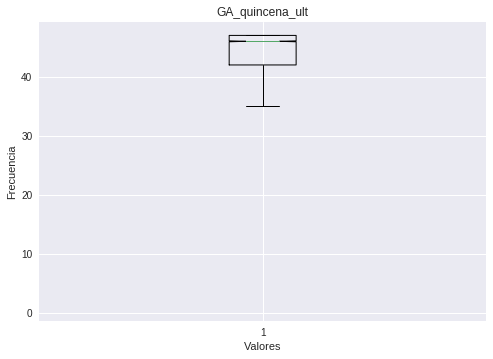

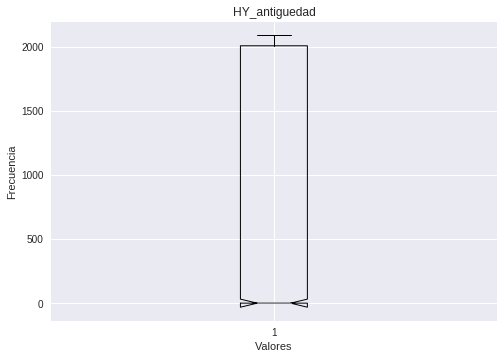

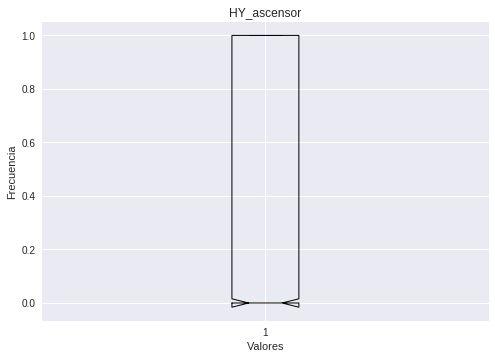

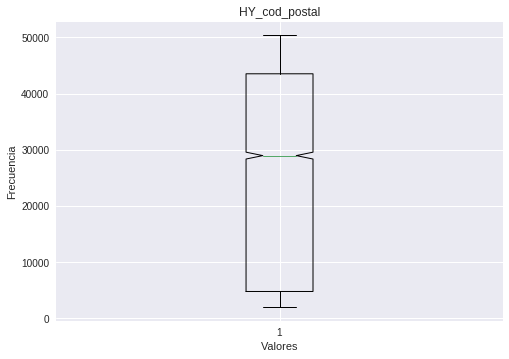

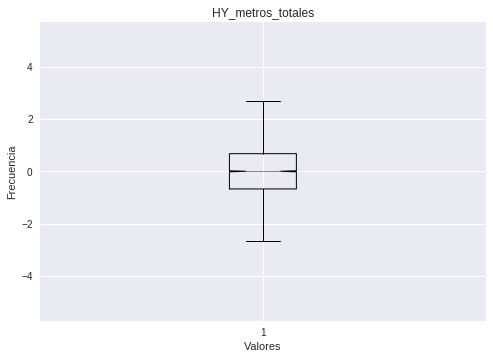

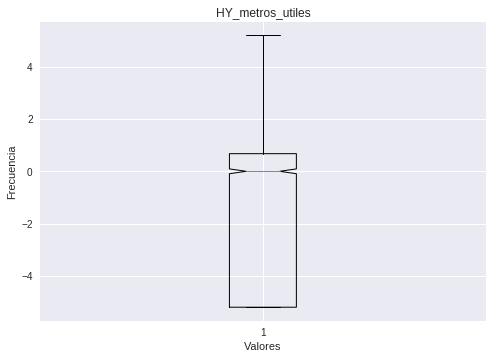

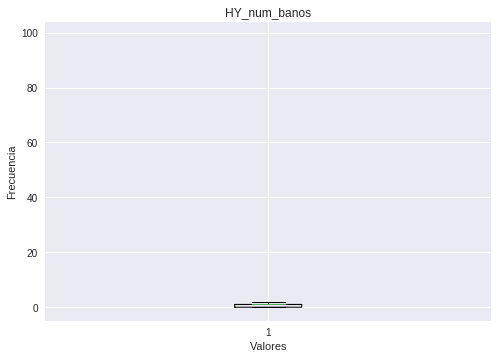

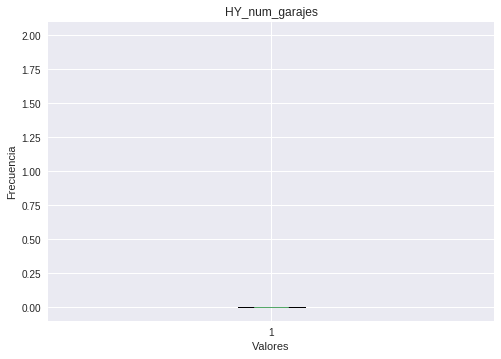

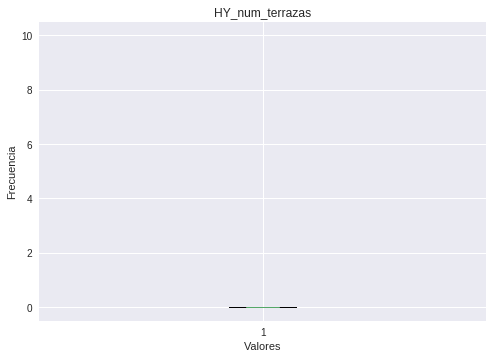

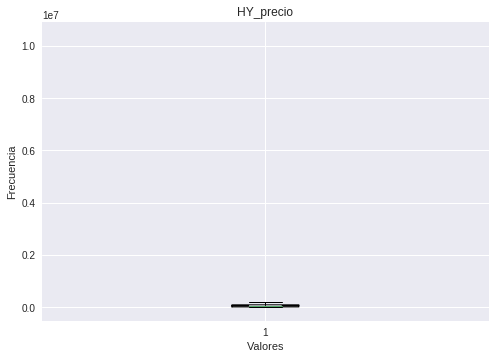

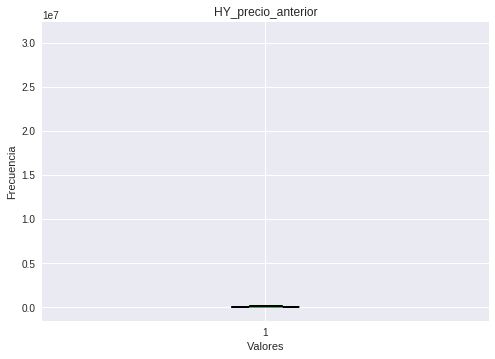

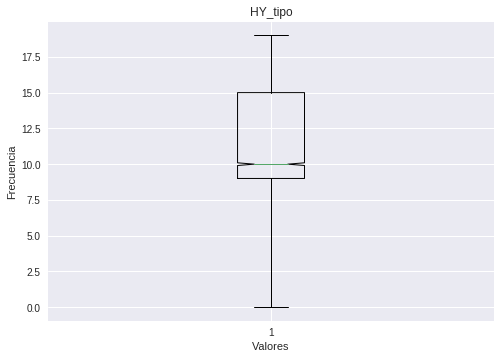

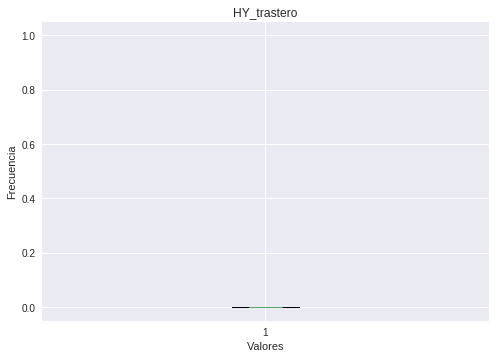

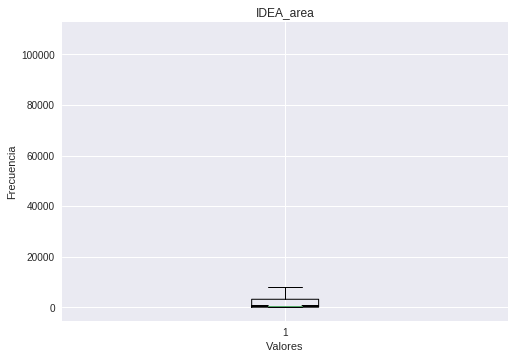

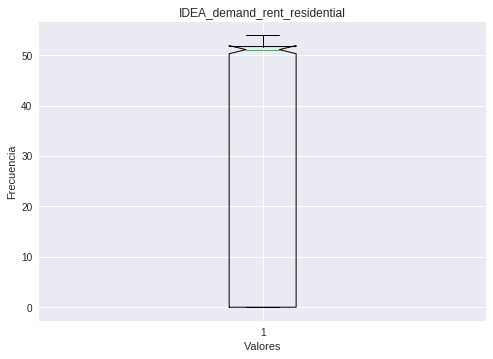

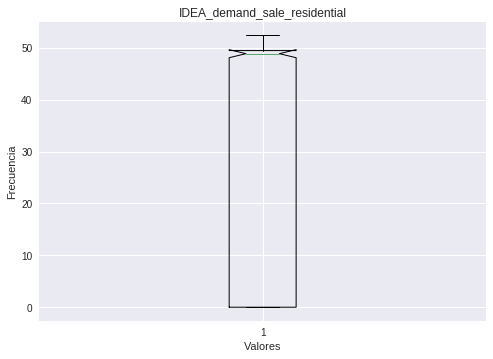

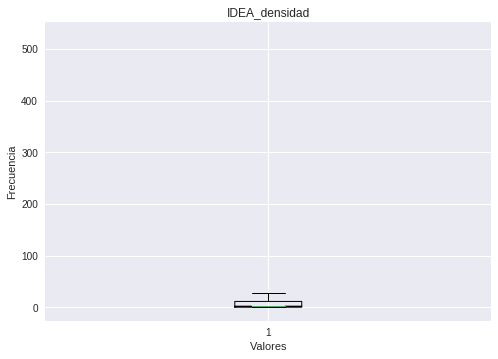

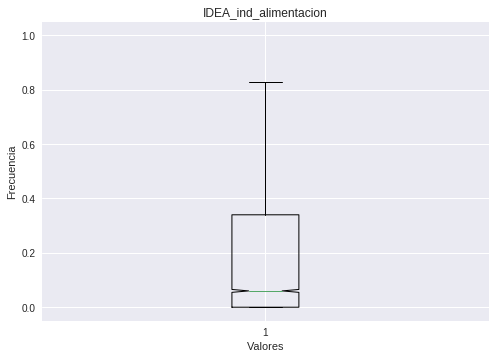

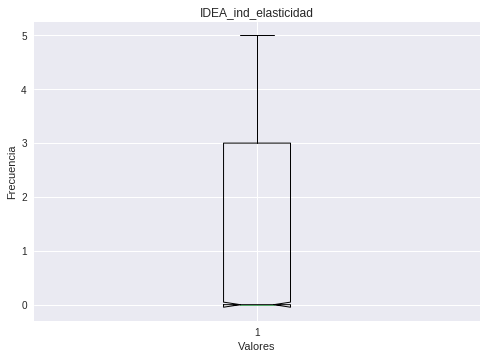

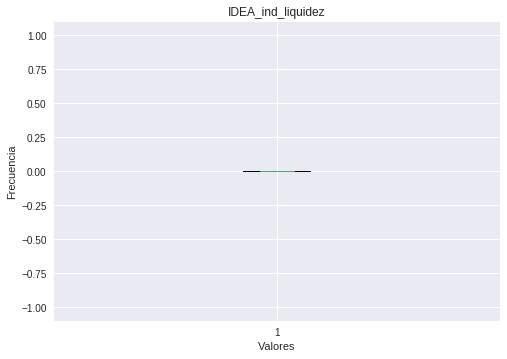

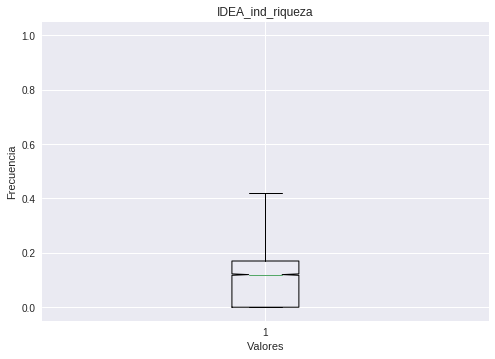

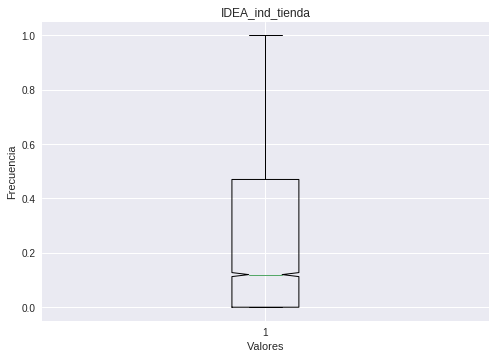

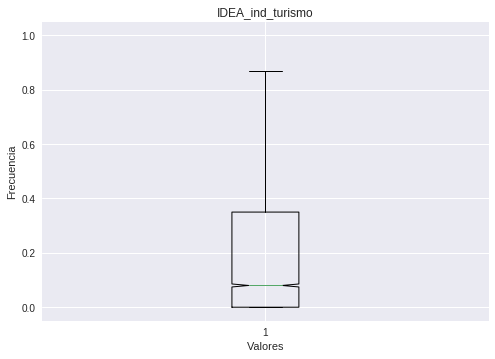

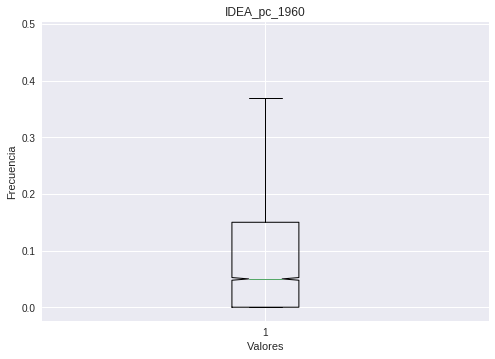

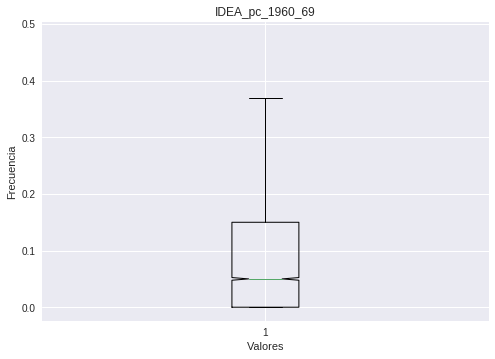

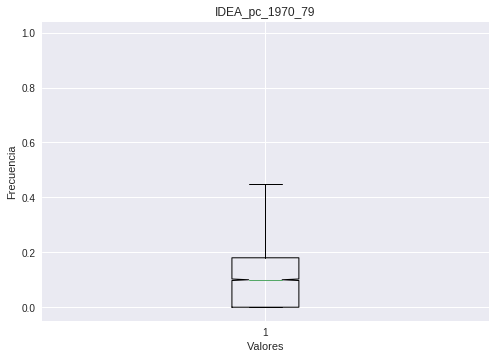

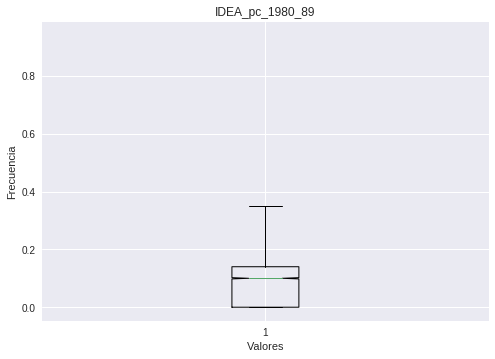

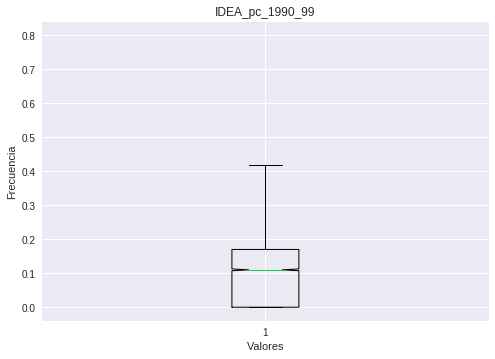

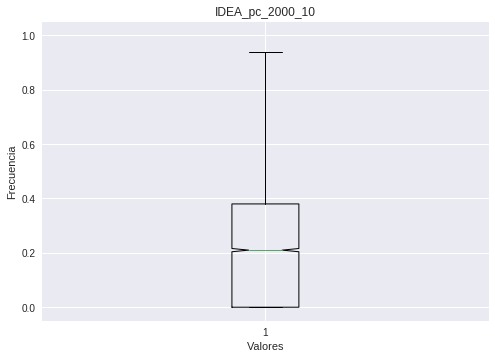

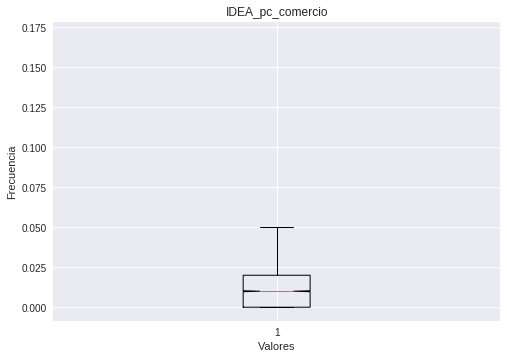

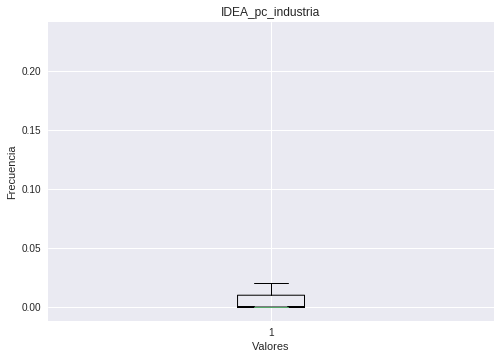

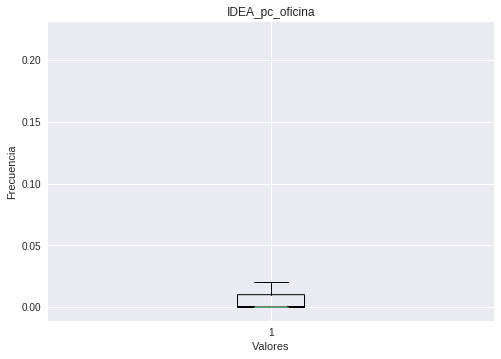

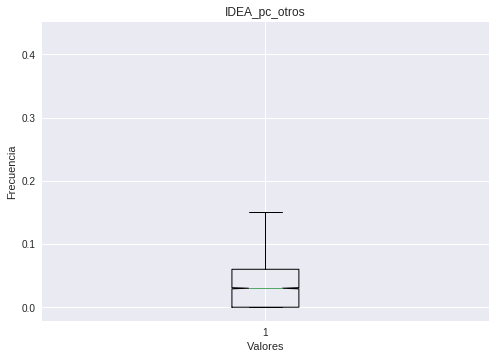

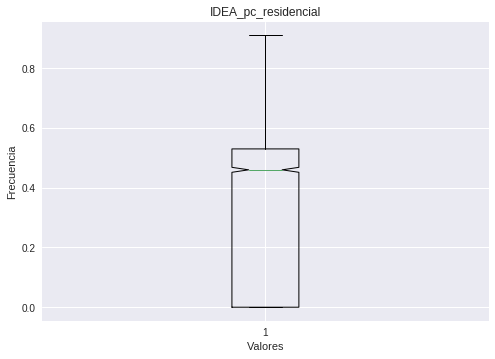

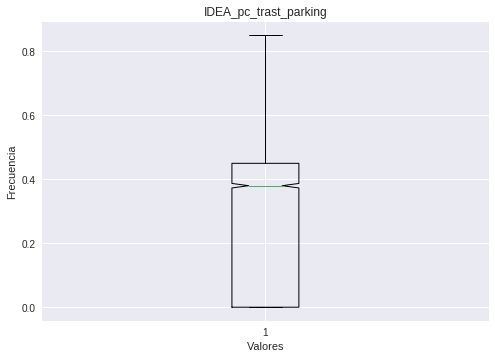

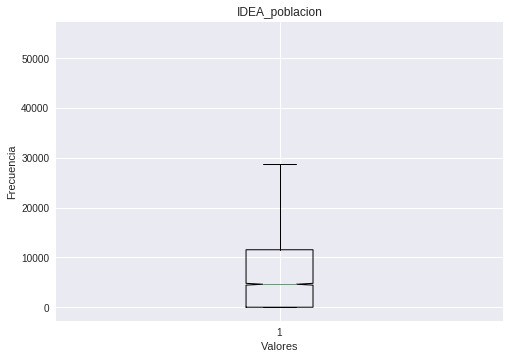

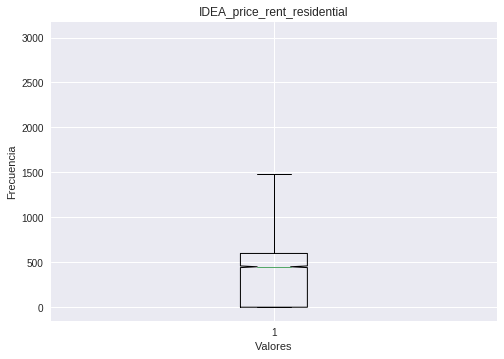

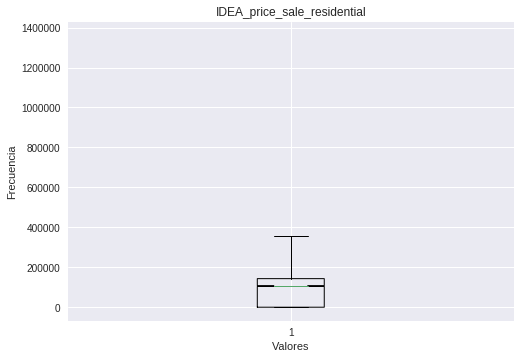

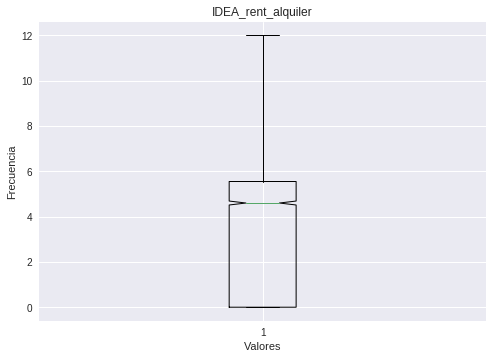

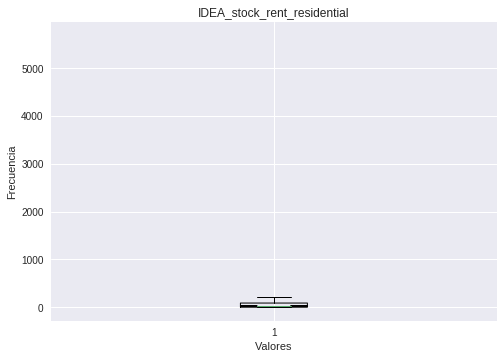

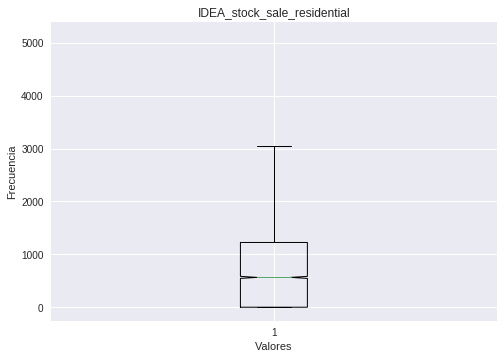

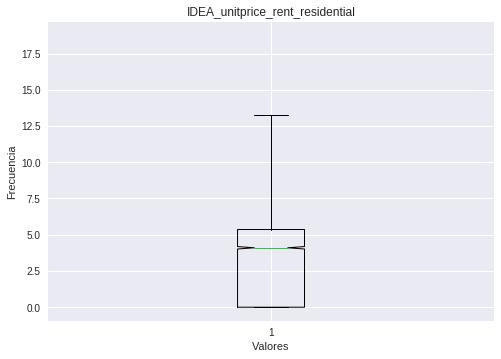

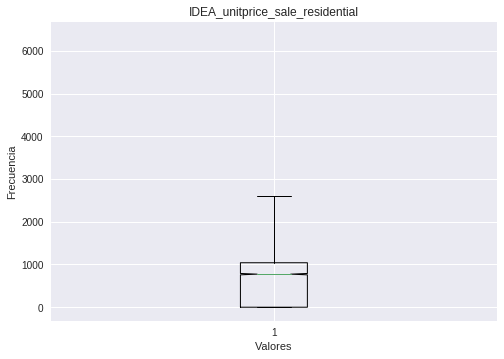

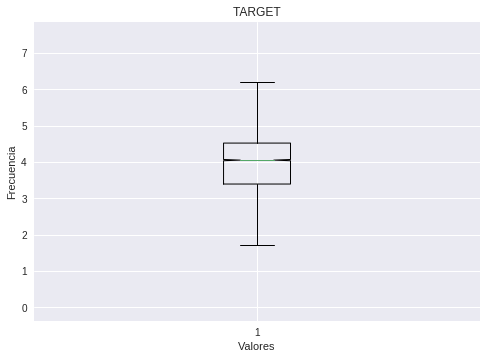

In [216]:
boxplots(s_df_model)

# CLASIFICACIÓN

#### Obtenemos las categorias predictoras por un lado  y el target por otro

In [0]:
colnames = s_df_model.columns.values.tolist()

In [0]:
predictors= colnames[0:len(colnames)-1] 
target= 'TARGET'# hay que tener en cuenta que se empieza en el cero

#### Separamos el conjunto en un conjunto de Training y un conjunto de Test

In [0]:
df_conj=s_df_model.copy()
df_conj["is_train"]= np.random.uniform(0,1,len(s_df_model))<=0.75

Partimos el conjunto en dos subconjuntos en función del valor -1 indicando cual era el training y el estimador

In [0]:
#s_df_model["is_train"]= s_df_model['TARGET'].values!=-1

Vemos en el histograma como se reparte los datos entre Train y test

(array([2476.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7482.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

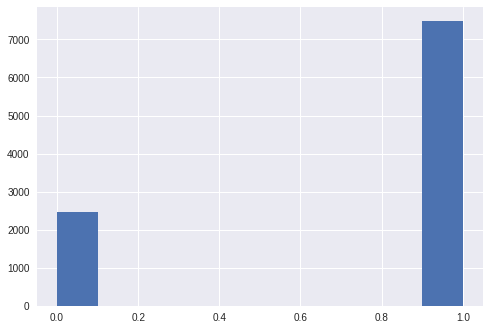

In [221]:
plt.hist(df_conj.is_train)

Partimos en test y train

In [0]:
train, test = df_conj[df_conj["is_train"]==True],df_conj[df_conj["is_train"]==False]
train.drop("is_train",axis=1,inplace=True)
test.drop("is_train",axis=1,inplace=True)

### Regression Tree 

Creamos el módelo

In [223]:
regtree= DecisionTreeRegressor(min_samples_split=5,min_samples_leaf=1,random_state=None)
regtree.fit(train[predictors],train[target])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

#### Prediction

In [0]:
to_predict=test
to_predict["regtree_preds"]= regtree.predict(to_predict[predictors])

#train[["regtree_preds","TARGET"]]

Median absolute error

In [0]:
mae_regtree=mean_absolute_error(np.exp(to_predict["TARGET"]),np.exp(to_predict["regtree_preds"]))                    

### Regression Random Forest
    

*   n_jobs-> número de tareas en paralelo
*   obb_score-> true(aleatorio)
*   n_estimators.-> núm. de estimadores que se va a tener



In [0]:
# forest= RandomForestRegressor(n_jobs=2,n_estimators=500)
# forest.fit(train[predictors],train[target])

#### prediction

In [0]:
# to_predict=test
# to_predict["rforest_preds"]=forest.predict(to_predict[predictors])

In [0]:
# mae_rforest=mean_absolute_error(np.expm1(to_predict["TARGET"]),np.expm1(to_predict["rforest_preds"]))

### Gradient Boosting Regressor

In [229]:
gradient= GradientBoostingRegressor(n_estimators=500, max_depth=5,min_samples_split=2,learning_rate=0.01)
gradient.fit(train[predictors],train[target])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

#### Prediction

In [0]:
to_predict=test
to_predict["gboost_preds"]=gradient.predict(to_predict[predictors])

In [0]:
mae_gboost=mean_absolute_error(np.expm1(to_predict["TARGET"]),np.expm1(to_predict["gboost_preds"]))

# RESULTADO (SCORE)

#### MAE de los clasificadores

In [232]:
# df_res_classifiers = pd.DataFrame({'mae_rforest': [mae_rforest], 'mae_regtree': [mae_regtree],'mae_gboost':[mae_gboost]})
df_res_classifiers = pd.DataFrame({'mae_regtree': [mae_regtree],'mae_gboost':[mae_gboost]})

df_res_classifiers

,mae_gboost,mae_regtree
0,35.736424,54.131373


#### Fichero final

In [0]:
# test["HY_id"]=df_model["HY_id"]
# test= test[["HY_id","regtree_preds"]]
# test= test.rename(columns={"regtree_preds":"TM_Est"})
# test.to_csv(r'Minsait_UJI_Math.random()_1.txt', header=True, index=None, sep='|', mode='w')
# df=pd.read_csv('Minsait_UJI_Math.random()_1.txt', sep="|")

In [0]:
# df.head()

# df.shape